In [6]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import joblib
import duckdb
import sys
from pathlib import Path

# Import from local modules
sys.path.append('../src')
import clustering_analysis
import processing_and_visualization

import importlib
importlib.reload(clustering_analysis)
importlib.reload(processing_and_visualization)

from clustering_analysis import print_cluster_examples, summarize_clusters, metacluster_preview
from processing_and_visualization import load_clustered_questions, plot_umap_centroids, collapsible_preview

load_dotenv()
csv_path = os.getenv("DATA_CSV")
parquet_path = os.getenv("DATA_PARQUET")

# Final Analysis of Question Clustering
This notebook reconstructs the clustered question datasets for the *unlabeled*, *chicken*, and *maize* subsets of English questions using the provided cluster label files (<20 MB) and the original full dataset. It also includes tools for inspecting and visualizing the cluster structure.

Together, these pieces allow users to explore the final clustering results without rerunning the full UMAP + HDBSCAN pipeline.

Quick facts about the full dataset:
* 20,304,843 rows in total
* 18,854,432 unique rows
* 5,452,290 unique questions
* 2,940,542 unique questions in English
* 16,283,143 unique responses
* 1,537,291 unique questions with no topic tag

Along with commentary, the rest of the notebook will go through the three clustered topics with the following:
- Visualization of the 2D UMAP projections of cluster centroids, color-coded by ChatGPT-assigned metacluster label.
- Bar plot of the amount of questions in each metacluster.
- Summary of HDBSCAN clusters, including TF-IDF keywords, 5 example questions, and metacluster label.
- A function to explore a single metacluster at a time in order to examine coherence.

**Note:** Cluster labels are specific to each subset and should not be mixed across datasets.


In [7]:
# Reassemble dataframes.
unlabeled_path = Path('../data/question_clusters_unlabeled.parquet')
chicken_path = Path('../data/question_clusters_chicken.parquet')
maize_path = Path('../data/question_clusters_maize.parquet')

unlabeled_df = load_clustered_questions(parquet_path, unlabeled_path, topic=None)
chicken_df = load_clustered_questions(parquet_path, chicken_path, topic="chicken")
maize_df = load_clustered_questions(parquet_path, maize_path, topic="maize")

In [8]:
# Map meta_label integers to descriptive titles
unlabeled_meta_titles = {
    -1: "Uncategorized", 1: "Soil & Fertilizer", 2: "Pests & Disease", 3: "Animal Husbandry", 4: "Planting & Growth", 
    5: "Markets", 6: "Finance & Loans", 7: "Farming Equipment & Materials", 8: "Weather & Environment", 
    9: "Wefarm Platform",10: "Personal Communication"
}

chicken_meta_titles = {
    -1: "Uncategorized", 1: "Chick Care & Raising", 2: "Nutrition & Feeding", 3: "Pests & Disease",
    4: "Adult Chicken Health & Behavior", 5: "Breeds & Genetics", 6: "Eggs & Reproduction",
    7: "Housing & Equipment", 8: "Business, Markets, & Starting Poultry Projects", 9: "Seasonal & Environmental Effects"
}

maize_meta_titles = {
    -1: "Uncategorized / Noise", 1: "Pests & Disease", 2: "Fertilizer, Soil, & Planting Practices", 3: "Seed Varieties & Regional Adaptation", 
    4: "Yield & Farm Output", 5: "Market & Price Information", 6: "Animal Feed / Alternative Uses", 7: "Wefarm Platform / Miscellaneous"   
}


unlabeled_df['meta_label_titles'] = unlabeled_df['meta_label'].map(unlabeled_meta_titles)
chicken_df['meta_label_titles'] = chicken_df['meta_label'].map(chicken_meta_titles)
maize_df['meta_label_titles'] = maize_df['meta_label'].map(maize_meta_titles)

## Unlabeled questions
This section explores question trends in the unlabeled questions in English, which consists of 643,148 questions-- about 42% of the total number of unlabeled questions. It is evident that non-English questions are more likely to lack a tag, as English questions represent 50.1% of unique questions overall.

These questions were clustered using minimal text cleaning, sentence embeddings (`all-MiniLM-L6-v2`), 5-dimensional UMAP, and HDBSCAN, with a second pass applied to noise (`-1`) questions and metaclusters created for interpretability.

Below, cluster centroids are plotted by their 2D UMAP coordinates, with point sizes normalized to the number of samples in each cluster and color-coded by metacluster. Clicking a metacluster in the legend will hide the others, allowing closer inspection of a single metacluster. Some clusters (e.g., **Personal Communication**) appear very close together in semantic space. For clusters like **Pests & Disease**, subjective inspection shows the metacluster is fairly cohesive; however, the different types of pests (insects, parasites, and monkeys) are likely well-separated from each other, as well as from bacterial diseases.

It also seems like unlabeled questions may be on average of lower quality than those with tags, which makes classification more difficult. The biggest cluster (68) seems to mostly contain broad, unfocused questions about **farms**. Examples include:
  - What are the importance of the farm?
  - I Want To Long Out Out From We Farm What Can I Do?
  - Q hi farmers
  - Q, WHAT IS THE BEST N LESS CAPITAL INTENSIVE AGRICULTURAL VENTURE TO PUT UP AS A STARTER
  - Among the  Mtds  Of Farming,which Method  z  best 2 use in dis season?

The second largest cluster (14) seems to have a more specific theme of **eggs**, and could probably have been tagged with **chicken**.
  - Q Need Supplier Of 500crates Of Eggs Every Week.
  - Q Is there any farmer with either kenbro,kari or rainbow rooster within nandi county?GIVE ME YOUR CONTACTS
  - Q eggs in uasin gishu? where and how much per tray?
  - Q what causes double york in eggs?
  - Q how do I increase egg laying

While there are clusters that probably could have been assigned one of the pre-existing crop/livestock tags (particularly in **Animal Husbandry**), there does appear to be a lot of questions focused on broader techniques and concepts. For example, while **fertilizer** may fall under specific crop tags, there are a lot of questions about fertilizers in general. Inspecting the original clusters, popular themes not covered by existing tags include:
 - Farm questions - equipment, irrigation, starting a farm, term definitions (e.g. organic farming))
 - Markets / Profitability
 - Fertilizer
 - Soil conditions (pH / chemistry, erosion, irrigation)
 - Vaccines
 - Food
 - Seeds
 - Pests & pesticides (fall armyworms seem like a common problem)
 - WeFarm platform (joining, leaving, competitions)
 - Disease
 - Weeds & herbicides
 - Weather
 - Personal conversation (sports, banter, romance, human sexuality-- cluster 36 is NSFW)


In [9]:
plot_umap_centroids(unlabeled_df, title="Unlabeled Questions - UMAP Centroids by Metacluster", size_scale=1)

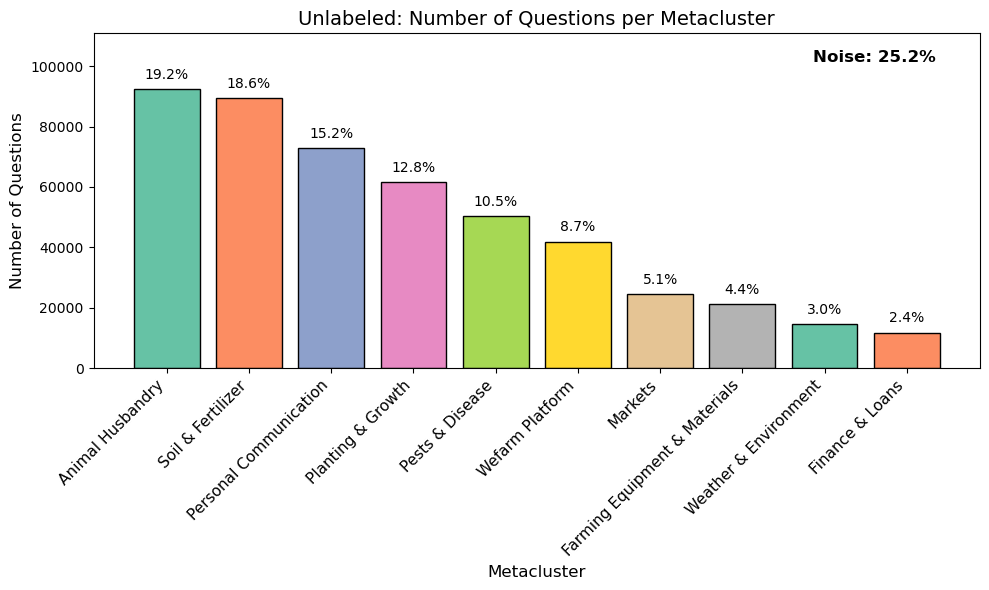

In [10]:
plot_metacluster_distribution(unlabeled_df, title="Unlabeled: Number of Questions per Metacluster")

In [11]:
## I've noticed a cluster that could be classified better-- I moved Cluster 68 from 'Personal Communication' to 'Farming Equipment & Materials'. This cluster seems to be mostly broad questions about farms (e.g. what is a farm?) 
## with maybe an emphasis on how to start one. This change just takes place here, so it will differ from the mapping in 'clustering_questions_unlabeled.ipynb'.
#  
## In case a future user wants to re-label other clusters, here's the mapping:

cluster_to_meta = {
    **dict.fromkeys([0, 12, 15, 16, 52, 53, 54, 57, 58, 59, 60, 83, 84, 87, 88, 91, 92, 98, 101, 108, 113, 118, 124, 126, 130, 137, 147, 151, 173, 175, 177, 182, 183, 188], 4),  # Planting & Growth
    **dict.fromkeys([1, 7, 9, 13, 34, 35, 45, 46, 47, 48, 85, 99, 107, 131, 133, 140, 144, 150, 165, 166, 168, 169], 2),  # Pests & Disease
    **dict.fromkeys([2, 3, 4, 5, 6, 10, 11, 14, 24, 26, 27, 29, 32, 55, 56, 81, 90, 95, 96, 102, 103, 117, 134, 143, 146, 156, 162, 171, 172, 178, 179, 191, 203], 3),  # Animal Husbandry
    **dict.fromkeys([8, 19, 20, 21, 22, 23, 33, 39, 40, 41, 43, 44, 49, 50, 65, 69, 75, 82, 94, 106, 110, 111, 114, 115, 116, 119, 120, 121, 123, 141, 142, 149, 153, 154, 155, 159, 164, 181, 210], 1),  # Soil, Fertilizer, & Animal Feed
    **dict.fromkeys([74, 122, 132, 148, 184, 185, 204, 205, 206, 207, 208, 209, 176, 174], 5),  # Markets
    **dict.fromkeys([17, 18, 71, 72, 186, 167, 163], 6),  # Finance & Loans
    **dict.fromkeys([25, 28, 31, 42, 68, 76, 86, 93, 100, 112, 129], 7),  # Farming Equipment & Materials
    **dict.fromkeys([30, 51, 97, 109, 128, 138, 180, 192], 8),  # Weather & Environment
    **dict.fromkeys([37, 61, 62, 67, 77, 80, 89, 139, 145, 187, 196, 198, 199], 9),  # Wefarm Platform
    **dict.fromkeys([36, 38, 63, 64, 70, 73, 78, 79, 125, 135, 136, 152, 157, 158, 160, 161, 189, 190, 193, 194, 195, 197, 200, 201, 202, 211, 212, 213, 214, 215, 216], 10),  # Personal Communication
    **dict.fromkeys([-1, 66, 104, 105, 127, 170], -1)  # Uncategorized
}
unlabeled_df['meta_label'] = unlabeled_df['cluster'].map(cluster_to_meta)
unlabeled_df['meta_label_titles'] = unlabeled_df['meta_label'].map(unlabeled_meta_titles)

In [12]:
unlabeled_summary = collapsible_preview(
    summarize_clusters,
    unlabeled_df,
    text_col='question_content',
    meta_col='meta_label_titles',
    sample_questions=5,
    preview=True,
    sort_by_size=True,
    summary_label="Unlabeled cluster summary"
)


In [13]:
collapsible_preview(metacluster_preview,
                    df = unlabeled_summary, 
                    metacluster_num=1, 
                    meta_titles=unlabeled_meta_titles)

## 'Chicken' Questions

This section will explore questions with the **chicken** tag, which represent 8.5% of the questions in English. Zoning in on one type of livestock question will hopefully reveal more global patterns in what information farmers are seeking about specific animals.

In [14]:
plot_umap_centroids(chicken_df, title="Chicken Questions - UMAP Centroids by Metacluster", size_scale=1)

As might be expected, the **chicken** focused clusters are more well-resolved than the **unlabeled** clusters-- an **unlabeled** metacluster like **Animal Husbandry** covers subject matter related to chickens, cows, goats, bees, and other animals. Focusing on chicken-specific content allows the clustering to capture finer distinctions within the topic, resulting in tighter, more clearly separated clusters.

The biggest metacluster is **Chick Care & Raising**. While there does seem to be a decent amount of chick-focused questions, its large size seems to be caused by some cross-contamination with general chicken questions and the fact that the largest cluster by a decent amount (0) was assigned to this metacluster. Cluster 0 is focused on vaccination-- it could have also been placed in **Pests & Diseases**.

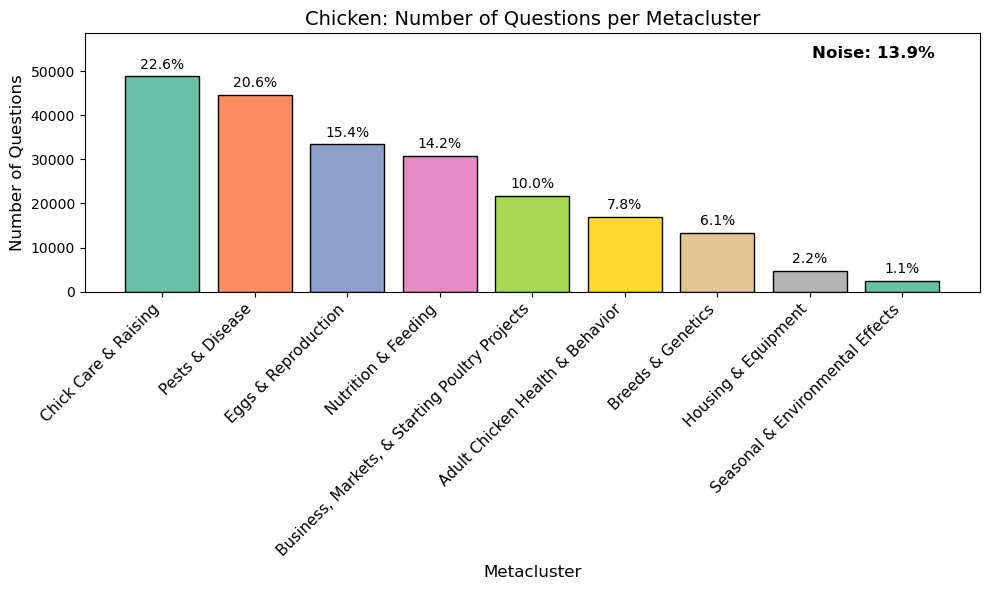

In [15]:
plot_metacluster_distribution(chicken_df, title="Chicken: Number of Questions per Metacluster")

In [16]:
## ChatGPT meta cluster assignment. Provided in case future user wants to change metacluster assignment 
cluster_to_meta = {
    **dict.fromkeys([0, 2, 36, 41, 43, 49, 59, 66, 67, 68, 70, 85, 105, 108, 118, 120], 1),  # Chick Care & Raising
    **dict.fromkeys([1, 8, 20, 21, 37, 40, 57, 58, 61, 62, 69, 78, 80, 81, 86, 88, 89, 91, 94, 98, 125], 2),  # Nutrition & Feeding
    **dict.fromkeys([3, 4, 5, 6, 9, 10, 11, 12, 13, 26, 30, 31, 33, 34, 47, 50, 51, 79, 84, 87, 92, 95, 100, 101, 102, 103, 109, 110, 111, 112, 114, 115, 116], 3),  # Pests & Disease
    **dict.fromkeys([23, 24, 25, 27, 28, 29, 32, 35, 44, 77], 4),  # Adult Chicken Health & Behavior
    **dict.fromkeys([15, 22, 42, 46, 53, 74, 75, 96, 97, 130, 104], 5),  # Breeds & Genetics
    **dict.fromkeys([16, 17, 38, 40, 52, 54, 63, 64, 65, 71, 72, 73, 76, 83, 99, 107, 113, 122, 124, 128, 129, 131, 132, 133], 6),  # Eggs & Reproduction
    **dict.fromkeys([39, 90, 93], 7),  # Housing & Equipment
    **dict.fromkeys([7, 14, 45, 48, 55, 56, 60, 106, 121, 123, 126, 127], 8),  # Business & Poultry Projects
    **dict.fromkeys([18, 19, 117], 9),  # Seasonal & Environmental Effects
    **dict.fromkeys([-1, 82, 119], -1),  # Uncategorized
}
chicken_df['meta_label'] = chicken_df['cluster'].map(cluster_to_meta)

In [24]:
# Generate summary of clusters, with largest at the top. Includes TF-IDF keywords and 5 example questions by default. Extra stop words can be added for TF-IDF if necessary.
chicken_summary = collapsible_preview(
                        summarize_clusters,
                        df = chicken_df, 
                        text_col='question_content',
                        meta_col='meta_label_titles',
                        sample_questions = 5, 
                        preview = True,
                        sort_by_size = True,
                        extra_stop_words = ["chicken", "chickens", "chiken"],
                        #random_samples = True
                        )

In [25]:
# Adjust metacluster_num to examine a specific metacluster. Dependent on summarize_clusters() output.
collapsible_preview(metacluster_preview,
                    df = chicken_summary, 
                    metacluster_num=1, 
                    meta_titles=chicken_meta_titles)

## 'Maize' Questions

This subsection will explore questions tagged with **maize**, which represent 6.3% of the English questions and constitute the largest crop topic in the dataset. Perhaps because maize is a specific crop and plant care is more straightforward than animal care, the 2D clustering map shows the best distinction between metaclusters of the 3 topics analyzed.

The clusters seem reasonably coherent, with many users displaying concern over market prices, growing techniques, and pests. Fall armyworms and leaf yellowing seem to be common problems.

In [19]:
plot_umap_centroids(maize_df, title="Maize Questions - UMAP Centroids by Metacluster", size_scale=1)

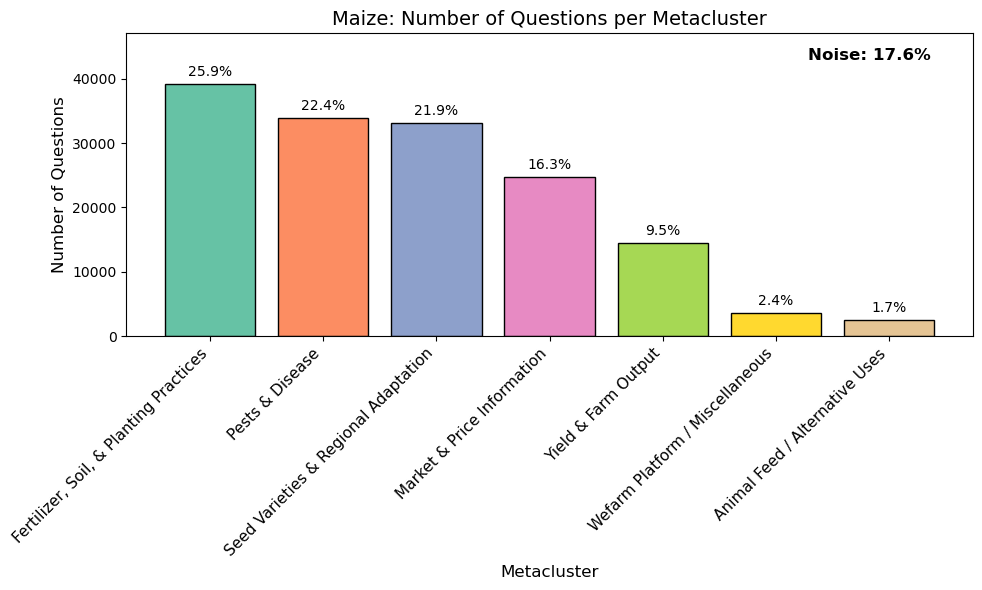

In [20]:
plot_metacluster_distribution(maize_df, title="Maize: Number of Questions per Metacluster")

In [21]:
# Formatted meta cluster assignment by ChatGPT-- check for missing assignments
cluster_to_meta_maize = {
    **dict.fromkeys([0, 1, 2, 15, 22, 26, 27, 29, 42, 47, 48, 50, 52, 53, 58, 83, 85, 87, 93, 97, 98, 107, 113, 114, 115, 116, 117, 122, 128], 1),  # Pests & Disease
    **dict.fromkeys([3, 4, 6, 7, 8, 10, 13, 14, 16, 17, 18, 19, 20, 51, 54, 55, 56, 77, 79, 84, 88, 90, 103, 104, 118, 120, 123, 127, 129, 134, 136, 138, 139], 2),  # Fertilizer, Soil, & Planting Practices
    **dict.fromkeys([12, 21, 23, 24, 25, 38, 39, 40, 41, 43, 46, 60, 65, 68, 69, 70, 71, 76, 78, 80, 81, 82, 91, 94, 95, 99, 100, 101, 102, 105, 106, 121, 124, 126, 133], 3),  # Seed Varieties & Regional Adaptation
    **dict.fromkeys([31, 33, 59, 63, 64, 66, 67, 72, 74, 75, 125, 131, 132, 135], 4),  # Yield & Farm Output
    **dict.fromkeys([9, 11, 28, 30, 32, 34, 35, 36, 37, 92, 96, 108, 109, 110, 111, 112, 119, 137], 5),  # Market & Price Information
    **dict.fromkeys([44, 45, 86, 89, 130], 6),  # Animal Feed / Alternative Uses
    **dict.fromkeys([49, 57, 61, 62, 140], 7),  # Wefarm / Miscellaneous
    **dict.fromkeys([-1, 5, 73], -1),  # Uncategorized / Noise
}
maize_df['meta_label'] = maize_df['cluster'].map(cluster_to_meta_maize)

In [26]:
# Generate summary of clusters, with largest at the top. Includes TF-IDF keywords and 5 example questions by default. Extra stop words can be added for TF-IDF if necessary.
maize_summary = collapsible_preview(
    summarize_clusters,
    df = maize_df, 
    text_col='question_content',
    meta_col='meta_label_titles',
    sample_questions = 5, 
    preview = True,
    sort_by_size = True,
    extra_stop_words = ["maize", "plant"],
    #random_samples = True
    )

In [27]:
# Adjust metacluster_num to examine a specific metacluster. Dependent on summarize_clusters() output.
collapsible_preview(
    metacluster_preview, 
    df = maize_summary, 
    metacluster_num=1, 
    meta_titles=maize_meta_titles)